In [1]:
# 设置工作目录为 "../../"
import os
os.chdir("../../")

In [2]:
import jax
import jax.numpy as jnp
from flax import linen as nn
import orbax.checkpoint as ocp
from jax import jit, random, vmap
import re
import os

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec
from matplotlib import font_manager

# load the font
font_dir = "./fonts/"
font_names = os.listdir(font_dir)
for font_name in font_names:
    font_manager.fontManager.addfont(font_dir + font_name)

rcParams.update({
    "font.size": 16,
    "font.family": "serif",
    "font.serif": ["Palatino Linotype"],
    "mathtext.fontset": "cm",
})
# jax.config.update("jax_enable_x64", True)  # 启用 float64 精度


In [3]:
import examples.fisher.configs as cfg
from examples.fisher.model import PINN

cfg = cfg.Config()
pinn = PINN(
    config=cfg,
)

ref_path = cfg.DATA_PATH
mesh = jnp.load(f"{cfg.DATA_PATH}/fisher_mesh.npy")
times = jnp.load(f"{cfg.DATA_PATH}/fisher_times.npy")
sol = jnp.load(f"{cfg.DATA_PATH}/fisher_sol.npy")
mesh.shape, times.shape, sol.shape

((201,), (102,), (102, 201))

In [4]:
ckpt = ocp.StandardCheckpointer()
state = ckpt.restore("/root/autodl-tmp/tf-logs/fisher/irr/baseline/model-20000/")
state_noirr = ckpt.restore("/root/autodl-tmp/tf-logs/fisher/noirr/baseline/model-20000/")
params = state["params"]
params_noirr = state_noirr["params"]

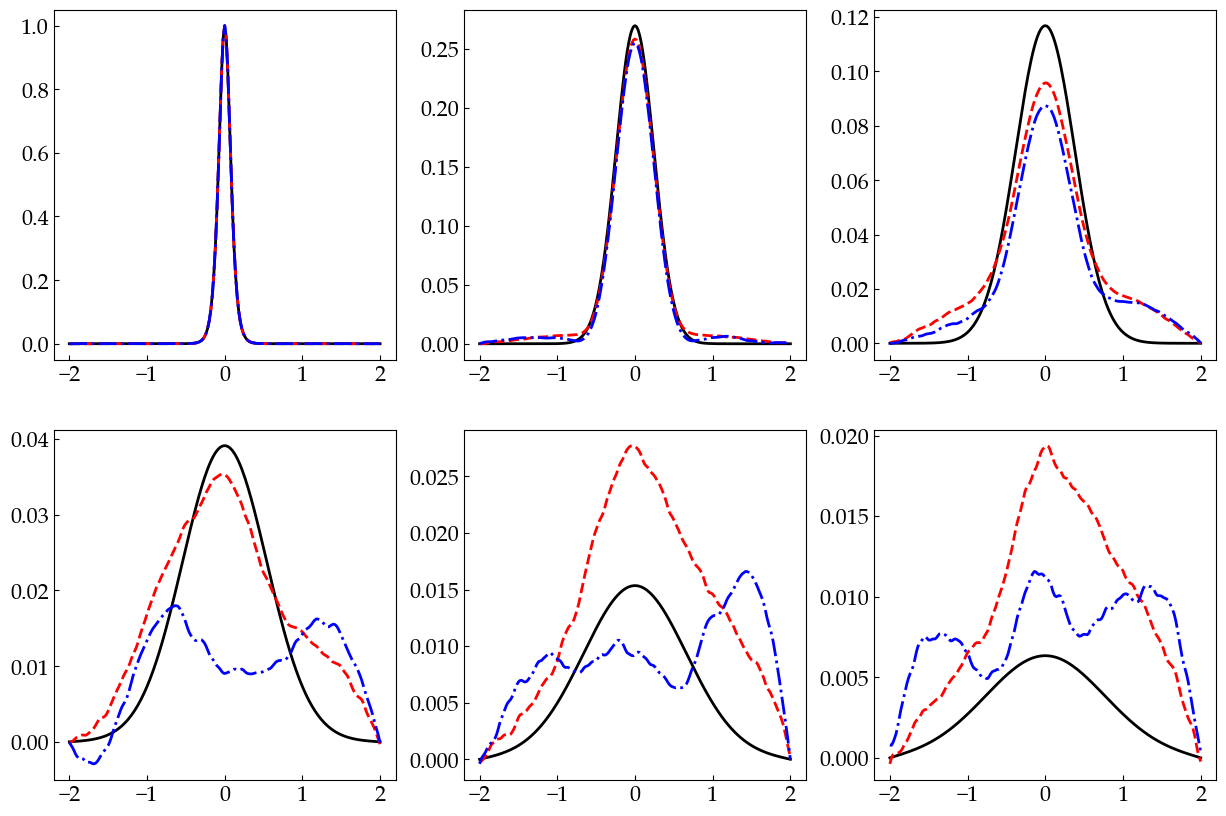

In [5]:
%matplotlib inline
ts = [0.0, 0.1, 0.25, 0.5, 0.75, 1.0]
times_indices = times.shape[0] * jnp.array(ts)
times_indices = times_indices.astype(jnp.int32).tolist() # indexes of times to show
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (tic_idx, ax) in enumerate(zip(times_indices, axes)):
    tic_show = times[tic_idx]  # actual time
    # plot the reference solution
    ax.plot(mesh, sol[tic_idx, :], 'k-', label='Reference', linewidth=2)

    tic_inp = jnp.ones_like(mesh) * tic_show
    pred_tic = vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params, mesh[:, None], tic_inp[:, None]).squeeze(-1)
    ax.plot(mesh, pred_tic, 'r--', label='With IRR', linewidth=2)

    pred_tic_noirr = vmap(
        pinn.net_u, in_axes=(None, 0, 0)
    )(params_noirr, mesh[:, None], tic_inp[:, None]).squeeze(-1)
    ax.plot(mesh, pred_tic_noirr, 'b-.', label='Without IRR', linewidth=2)

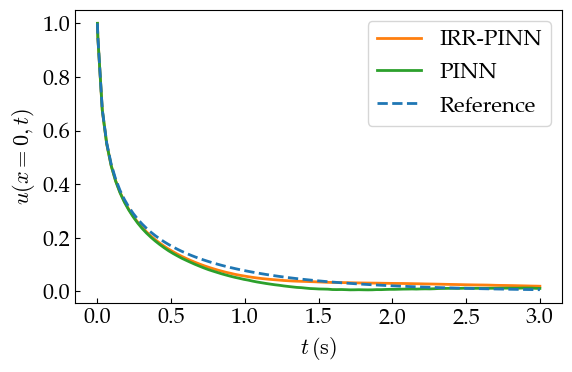

In [67]:
fig, ax = plt.subplots(figsize=(6, 4))
mesh_inp = jnp.zeros_like(times)

pred = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, mesh_inp[:, None], times[:, None]).squeeze(-1)
ax.plot(times, pred, color="C1", lw=2, label="IRR-PINN",)

pred_noirr = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params_noirr, mesh_inp[:, None], times[:, None]).squeeze(-1)
ax.plot(times, pred_noirr,  color="C2", lw=2, label="PINN")

x0_loc = jnp.argmin(jnp.abs(mesh - 0.0))
ax.plot(times, sol[:, x0_loc],  color="C0", linestyle="--", lw=2, label="Reference")
ax.legend()
ax.set_xlabel(r"$t\,\mathrm{(s)}$")
ax.set_ylabel("$u(x=0,t)$")
fig.tight_layout()
fig.savefig("figures/fisher-peak.png", dpi=300, bbox_inches='tight')

Text(0.5, 0, 'u')

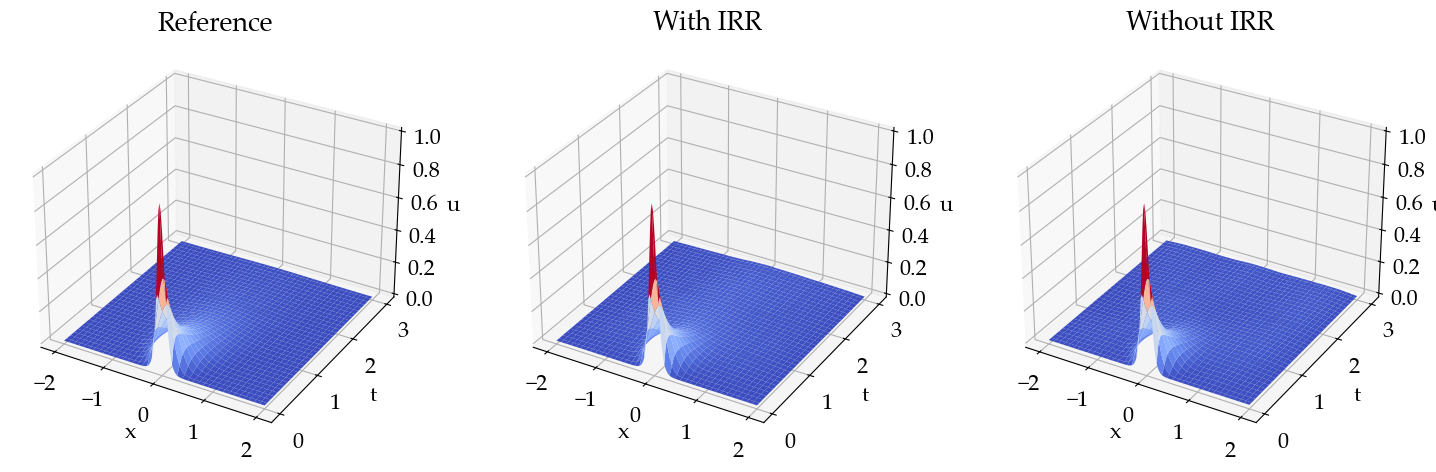

In [8]:
fig = plt.figure(figsize=(18, 10))

# 第一行：三个3D曲面图
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
X, Y = jnp.meshgrid(mesh, times)
ax1.plot_surface(X, Y, sol, cmap='coolwarm')
ax1.set_title("Reference")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_zlabel("u")

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
x_inp = X.flatten()
y_inp = Y.flatten()
pred = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, x_inp[:, None], y_inp[:, None]).squeeze(-1)
Z_irr = pred.reshape(X.shape)
ax2.plot_surface(X, Y, Z_irr, cmap='coolwarm')
ax2.set_title("With IRR")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u")

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
pred_noirr = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params_noirr, x_inp[:, None], y_inp[:, None]).squeeze(-1)
Z_noirr = pred_noirr.reshape(X.shape)
ax3.plot_surface(X, Y, Z_noirr, cmap='coolwarm')
ax3.set_title("Without IRR")
ax3.set_xlabel("x")
ax3.set_ylabel("t")
ax3.set_zlabel("u")

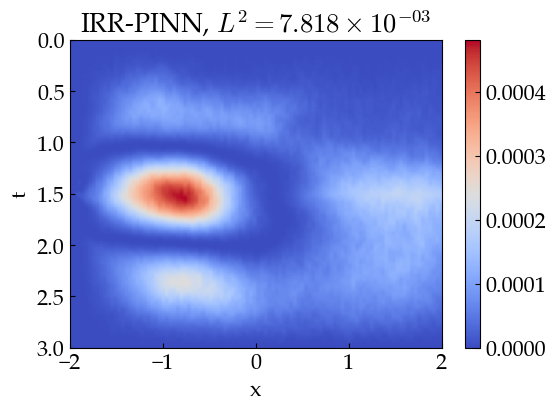

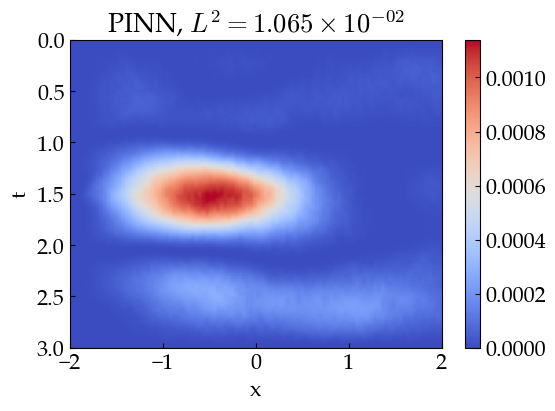

In [68]:
# fig = plt.figure(figsize=(14, 3.5))
# gs = GridSpec(1, 5, figure=fig, width_ratios=[1, 0.05, 0.1, 1, 0.05],)

# X, Y = jnp.meshgrid(mesh, times)
# x_inp = X.flatten()
# y_inp = Y.flatten()

# ax = fig.add_subplot(gs[0, 0])
# pred = vmap(
#     pinn.net_u, in_axes=(None, 0, 0)
# )(params, x_inp[:, None], y_inp[:, None]).squeeze(-1)
# Z_irr = pred.reshape(X.shape)
# Z_irr = (Z_irr - sol) ** 2
# im1 = ax.imshow(Z_irr.T, extent=[mesh.min(), mesh.max(), times.max(), times.min()], 
#                       cmap='coolwarm', aspect='auto')
# L2 = jnp.sqrt(jnp.mean(Z_irr))
# ax.set_title(f"IRR-PINN, $L^2$ Error: {L2:.2e}")

# ax_bar = fig.add_subplot(gs[0, 1])
# fig.colorbar(im1, cax=ax_bar)
# ax_bar.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))

# ax = fig.add_subplot(gs[0, 3])
# pred_noirr = vmap(
#     pinn.net_u, in_axes=(None, 0, 0)
# )(params_noirr, x_inp[:, None], y_inp[:, None]).squeeze(-1)
# Z_noirr = pred_noirr.reshape(X.shape)
# Z_noirr = (Z_noirr - sol) ** 2
# im2 = ax.imshow(Z_noirr.T, extent=[mesh.min(), mesh.max(), times.max(), times.min()], 
#                      cmap='coolwarm', aspect='auto')
# L2_noirr = jnp.sqrt(jnp.mean(Z_noirr))
# ax.set_title(f"PINN, $L^2$ Error: {L2_noirr:.2e}")

# ax_bar = fig.add_subplot(gs[0, 4])
# fig.colorbar(im2, cax=ax_bar, )
# ax_bar.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1e'))
# # fig.tight_layout()

fig, ax = plt.subplots(figsize=(6, 4))

X, Y = jnp.meshgrid(mesh, times)
x_inp = X.flatten()
y_inp = Y.flatten()

pred = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params, x_inp[:, None], y_inp[:, None]).squeeze(-1)
Z_irr = pred.reshape(X.shape)
Z_irr = (Z_irr - sol) ** 2
im1 = ax.imshow(Z_irr.T, extent=[mesh.min(), mesh.max(), times.max(), times.min()], 
                      cmap='coolwarm', aspect='auto')
error = jnp.sqrt(jnp.mean(Z_irr))
error_str = "$L^2=" + f"{error:.3e}".replace("e", r"\times 10^{") + "}$"
ax.set_title(f"IRR-PINN, {error_str}")
fig.colorbar(im1, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("t")
fig.savefig("figures/fisher_error_irr.png", dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(6, 4))
pred_noirr = vmap(
    pinn.net_u, in_axes=(None, 0, 0)
)(params_noirr, x_inp[:, None], y_inp[:, None]).squeeze(-1)
Z_noirr = pred_noirr.reshape(X.shape)
Z_noirr = (Z_noirr - sol) ** 2
im2 = ax.imshow(Z_noirr.T, extent=[mesh.min(), mesh.max(), times.max(), times.min()], 
                     cmap='coolwarm', aspect='auto')
error_noirr = jnp.sqrt(jnp.mean(Z_noirr))
error_str_noirr = "$L^2=" + f"{error_noirr:.3e}".replace("e", r"\times 10^{") + "}$"
ax.set_title(f"PINN, {error_str_noirr}")
fig.colorbar(im2, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("t")
fig.savefig("figures/fisher_error_noirr.png", dpi=300, bbox_inches='tight')

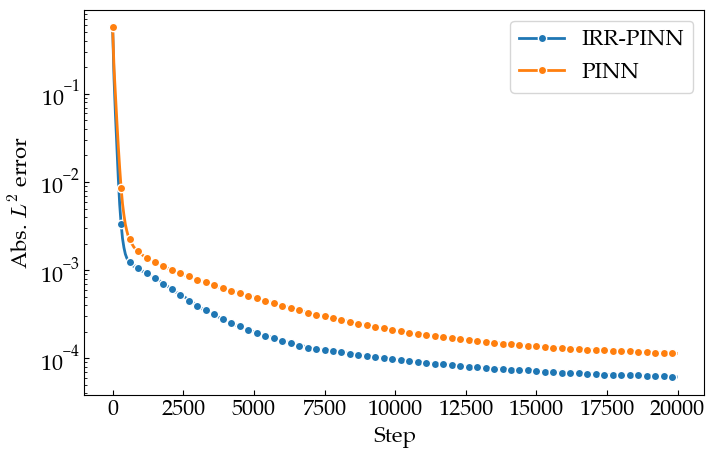

In [75]:
import pandas as pd

error_log = pd.read_csv("./logs-eval/run-fisher_irr_baseline-tag-error.csv")
error_log_noirr = pd.read_csv("./logs-eval/run-fisher_noirr_baseline-tag-error.csv")

error_log = error_log[error_log["Step"] < 20000]
error_log_noirr = error_log_noirr[error_log_noirr["Step"] < 20000]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(error_log["Step"], error_log["Value"], label="IRR-PINN", lw=2, markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(error_log_noirr["Step"], error_log_noirr["Value"], label="PINN", lw=2,markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Abs. $L^2$ error", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
plt.savefig("figures/fisher-error-log.png", dpi=300, bbox_inches="tight")

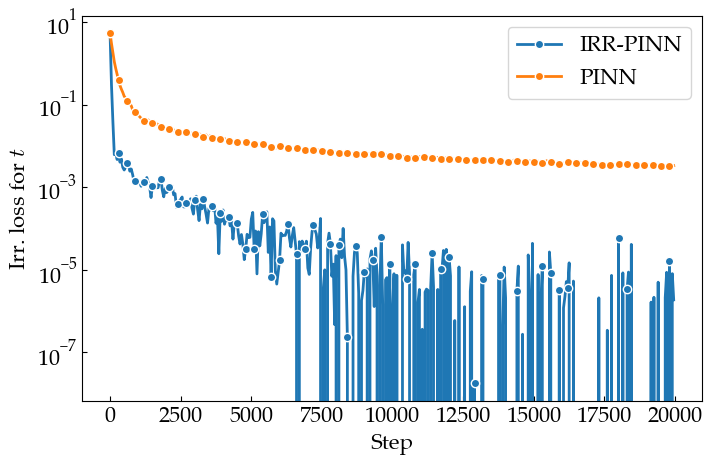

In [83]:
import pandas as pd

error_log = pd.read_csv("./logs-eval/run-fisher_irr_baseline-tag-loss_irr_t.csv")
error_log_noirr = pd.read_csv("./logs-eval/run-fisher_noirr_baseline-tag-loss_irr_t.csv")

error_log = error_log[error_log["Step"] < 20000]
error_log_noirr = error_log_noirr[error_log_noirr["Step"] < 20000]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(error_log["Step"], error_log["Value"], label="IRR-PINN", lw=2, markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(error_log_noirr["Step"], error_log_noirr["Value"], label="PINN", lw=2,markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Irr. loss for $t$", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
plt.savefig("figures/fisher-irrlosst-log.png", dpi=300, bbox_inches="tight")

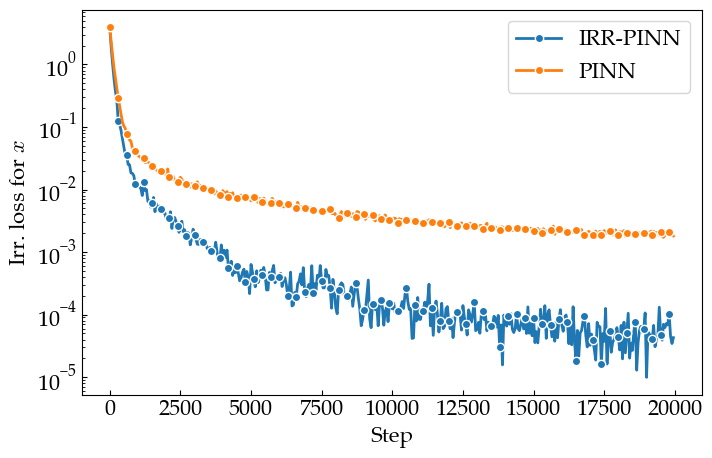

In [85]:
import pandas as pd

error_log = pd.read_csv("./logs-eval/run-fisher_irr_baseline-tag-loss_irr_x.csv")
error_log_noirr = pd.read_csv("./logs-eval/run-fisher_noirr_baseline-tag-loss_irr_x.csv")

error_log = error_log[error_log["Step"] < 20000]
error_log_noirr = error_log_noirr[error_log_noirr["Step"] < 20000]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(error_log["Step"], error_log["Value"], label="IRR-PINN", lw=2, markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.plot(error_log_noirr["Step"], error_log_noirr["Value"], label="PINN", lw=2,markevery=6,
        marker="o", markeredgecolor="white", markersize=6, markeredgewidth=1)
ax.set(ylabel="Irr. loss for $x$", xlabel="Step", yscale="log")
ax.legend(loc="upper right",)
plt.savefig("figures/fisher-irrlossx-log.png", dpi=300, bbox_inches="tight")